# Deepseek MLA在MHA与MQA模式的运算量对比

MLA（Multi-head Latent Attention）存在两种计算形态：非吸收矩阵（MHA模式）与吸收矩阵（MQA模式）。

这两种模式在计算量上究竟有多少差异？又分别适用于什么场景？本文将通过具体分析，带您探寻问题的答案。

主要内容包括：

- 建立两种模式下的MFU（Model FLOPs Utilization）函数，量化其计算效率。

- 寻找导致算力差异的序列长度临界值，明确性能优势的转换边界。

相关文章：

[超细图解MLA计算流&吸收矩阵对比分析](https://zhuanlan.zhihu.com/p/1948769945132470860)

Author: kaiyuan

Email: kyxie@zju.edu.cn

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# MLA的相关参数，参考DeepSeekV3参数
bs = 1
heads = 128
qk_head_dim = 128
kv_lora_rank = 512
h_dim = 7168
q_lora_rank = 1536
qk_rope_head_dim = 64
v_head_dim = 128
n_heads = v_head_dim
causal_mask_cof = 1 # casual mask是否启用 开启等于2，关闭等于1


In [ ]:

# MHA模式，非吸收矩阵计算:
def calc_mla_non_absorb_flops(seq_len, cache_len=0):
    q_down_proj = 2 * bs * seq_len * h_dim * q_lora_rank
    q_up_proj = 2 * bs * seq_len * q_lora_rank * heads * (qk_head_dim + qk_rope_head_dim)
    q_linear = q_down_proj + q_up_proj

    kv_down_proj = 2 * bs * seq_len * h_dim * (kv_lora_rank + qk_rope_head_dim)
    kv_up_proj = 2 * bs * heads * (seq_len + cache_len) * kv_lora_rank * (qk_head_dim + v_head_dim)
    kv_linear = kv_down_proj + kv_up_proj

    kv_scores = 2 * bs * heads * seq_len * (seq_len + cache_len) * (qk_head_dim + qk_rope_head_dim) / causal_mask_cof
    qkv = 2 * bs * heads * seq_len * (seq_len + cache_len) * v_head_dim / causal_mask_cof
    out = 2 * bs * seq_len * n_heads * v_head_dim * h_dim
    attention = kv_scores + qkv
    mla_non_absorb_flops = attention + kv_linear + q_linear + out
    return mla_non_absorb_flops, q_linear, kv_linear, attention, out


# MQA模式，吸收矩阵计算:
def calc_mla_absorb_flops(seq_len, cache_len=0):
    q_down_proj = 2 * bs * seq_len * h_dim * q_lora_rank
    q_up_proj = 2 * bs * seq_len * q_lora_rank * heads * (qk_head_dim + qk_rope_head_dim)
    q_absorb = 2 * bs * heads * seq_len * qk_head_dim * kv_lora_rank

    q_linear = q_down_proj + q_up_proj + q_absorb

    kv_down_proj = 2 * bs * seq_len * h_dim * (kv_lora_rank + qk_rope_head_dim)
    kv_linear = kv_down_proj

    kv_scores = 2 * bs * heads * seq_len * (seq_len + cache_len) * (kv_lora_rank + qk_rope_head_dim) / causal_mask_cof
    qkv = 2 * bs * heads * seq_len * (seq_len + cache_len) * kv_lora_rank / causal_mask_cof
    out_absorb = 2 * bs * seq_len * heads * kv_lora_rank * v_head_dim
    out = 2 * bs * seq_len * n_heads * v_head_dim * h_dim + out_absorb
    attention = kv_scores + qkv
    mla_absorb_flops = attention + kv_linear + q_linear + out

    return mla_absorb_flops, q_linear, kv_linear, attention, out


def convert_flops(flops, cof=1024 * 1024 * 1024):
    return flops / cof


# 打印函数：
def print_data(str_name, non_absorb, absorb, unit="TFlops"""):
    print(f"{str_name}非吸收矩阵{convert_flops(non_absorb)} {unit} 吸收矩阵{convert_flops(absorb)} {unit} "
          f"差值：{convert_flops(non_absorb) - convert_flops(absorb)} {unit}")

# 绘制曲线
def plot_data(seq_len=0, cache_len=0, x_lab="seq_len"):
    x_values = []
    y_values = []
    for change_len in range(0, 100, 10):
        x_values.append(change_len)
        if x_lab == "seq_len":
          seq_len = change_len
        else:
          cache_len = change_len
        y_values.append(convert_flops(calc_mla_non_absorb_flops(seq_len, cache_len)[0] - calc_mla_absorb_flops(seq_len, cache_len)[0]))


    plt.figure(figsize=(10, 6))
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', linewidth=2)
    if x_lab == "seq_len":
      plt.title(f"cache_seq={cache_len}", fontsize=14)
      plt.xlabel("seq_len", fontsize=12)
    else:
      plt.title(f"seq_len={seq_len}", fontsize=14)
      plt.xlabel("cache_seq", fontsize=12)
    plt.ylabel("Diff: non-absorb - absorb Tflops", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    for i, (x, y) in enumerate(zip(x_values, y_values)):
        plt.annotate(f'{y:.1f}', (x, y), textcoords="offset points",
                     xytext=(0, 10), ha='center', fontsize=9)

    plt.show()


In [ ]:
# seq_len输入的tokens长度，表示cache的长度：
seq_len = 10
cache_len = 0

mla_non_absorb_flops, q_linear, kv_linear, attention, out = calc_mla_non_absorb_flops(seq_len, cache_len)
mla_absorb_flops, absorb_q_linear, absorb_kv_linear, absorb_attention, absorb_out = calc_mla_absorb_flops(seq_len,
                                                                                                          cache_len)
print_data("整体运算量", mla_non_absorb_flops, mla_absorb_flops)
print_data("q_linear", q_linear, absorb_q_linear)
print_data("kv_linear", kv_linear, absorb_kv_linear)
print_data("attention", attention, absorb_attention)
print_data("out", out, absorb_out)

整体运算量非吸收矩阵3.49273681640625 TFlops 吸收矩阵3.51104736328125 TFlops 差值：-0.018310546875 TFlops
q_linear非吸收矩阵0.908203125 TFlops 吸收矩阵1.064453125 TFlops 差值：-0.15625 TFlops
kv_linear非吸收矩阵0.389404296875 TFlops 吸收矩阵0.076904296875 TFlops 差值：0.3125 TFlops
attention非吸收矩阵0.00762939453125 TFlops 吸收矩阵0.02593994140625 TFlops 差值：-0.018310546875 TFlops
out非吸收矩阵2.1875 TFlops 吸收矩阵2.34375 TFlops 差值：-0.15625 TFlops


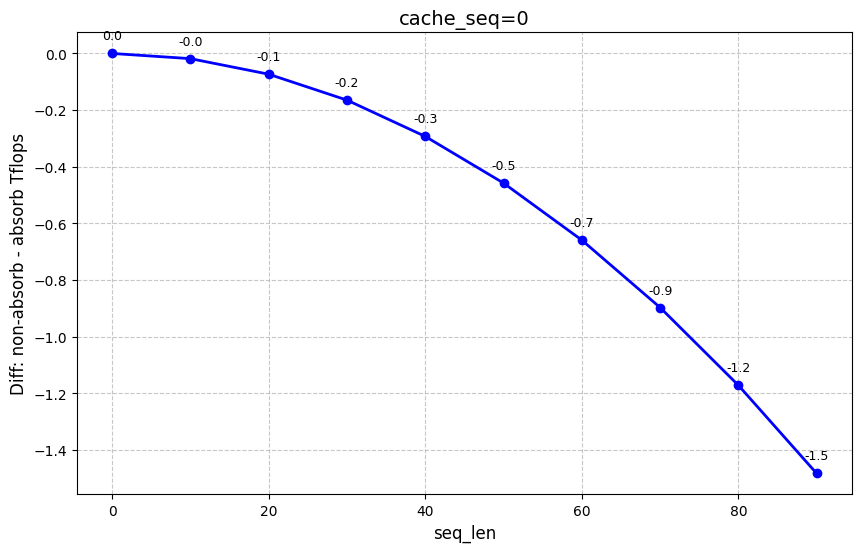

In [ ]:
# 在prefill阶段 cache=0
plot_data(cache_len=0, x_lab="seq_len")

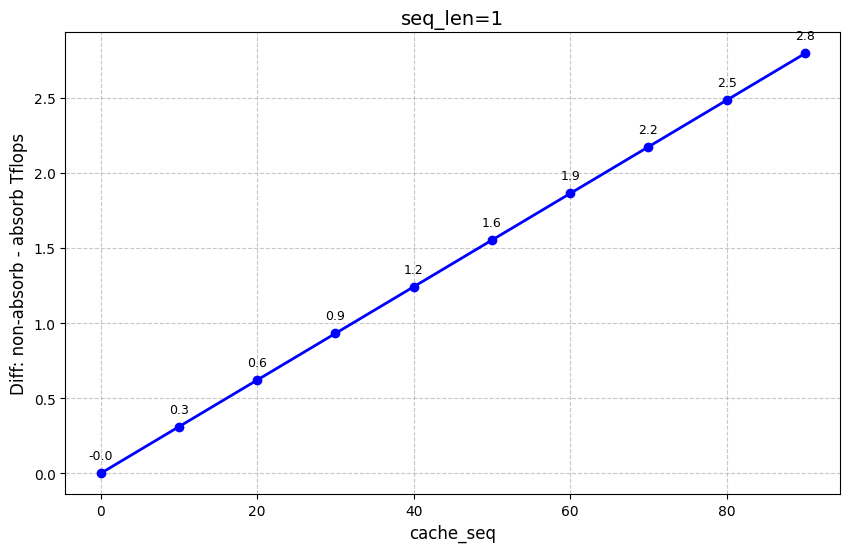

In [ ]:
# 在decode阶段seq_len=1
plot_data(seq_len=1, x_lab="cache_len")

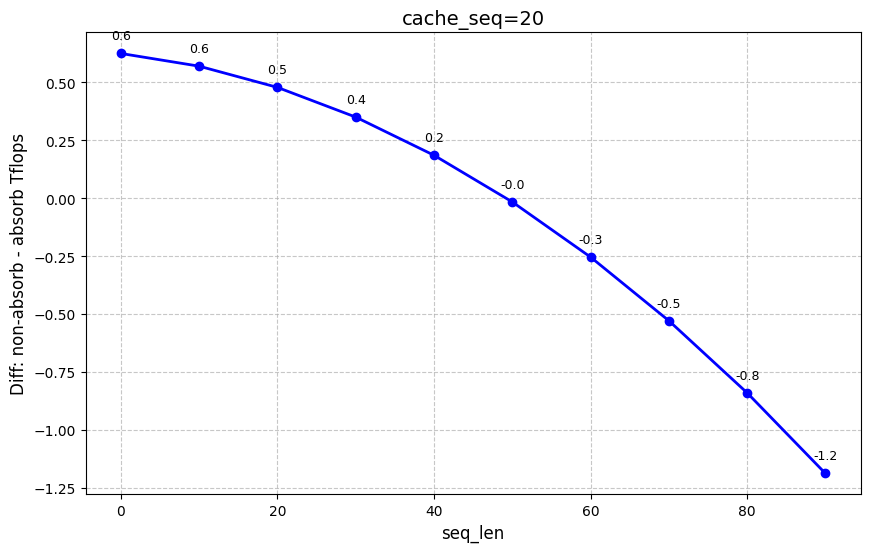

In [ ]:
# 在prefill阶段 cache=20
plot_data(cache_len=20, x_lab="seq_len")

## Diff的公式建立：

1、把两种类型的计算作差,公式化简

2、绘制三维图像

In [ ]:
# 消除相同部分：
diff_0 = 2 * bs * heads * (seq_len * v_head_dim + cache_len * (qk_head_dim + v_head_dim)) * kv_lora_rank
diff_1 = 2 * bs * heads * seq_len * (seq_len + cache_len) * (qk_head_dim - kv_lora_rank)
diff_2 = 2 * bs * heads * seq_len * ((seq_len + cache_len) * (v_head_dim - kv_lora_rank) - kv_lora_rank * v_head_dim)
print("公式计算结果：", convert_flops(diff_0 + diff_1 + diff_2))

# 代入具体参数：
diff = ((128 * seq_len + 256 * cache_len) * 512 +
        seq_len * (seq_len + cache_len) * (128 - 512) +
        seq_len * ((seq_len + cache_len) * (128 - 512) - 512 * 128))
# 化简：
diff = 131072 * cache_len - 768 * seq_len ** 2 - 768 * seq_len * cache_len

# 乘以公共参数：
diff *= 2 * bs * heads

print("简化公式计算结果：", convert_flops(diff))


公式计算结果： -0.018310546875
简化公式计算结果： -0.018310546875


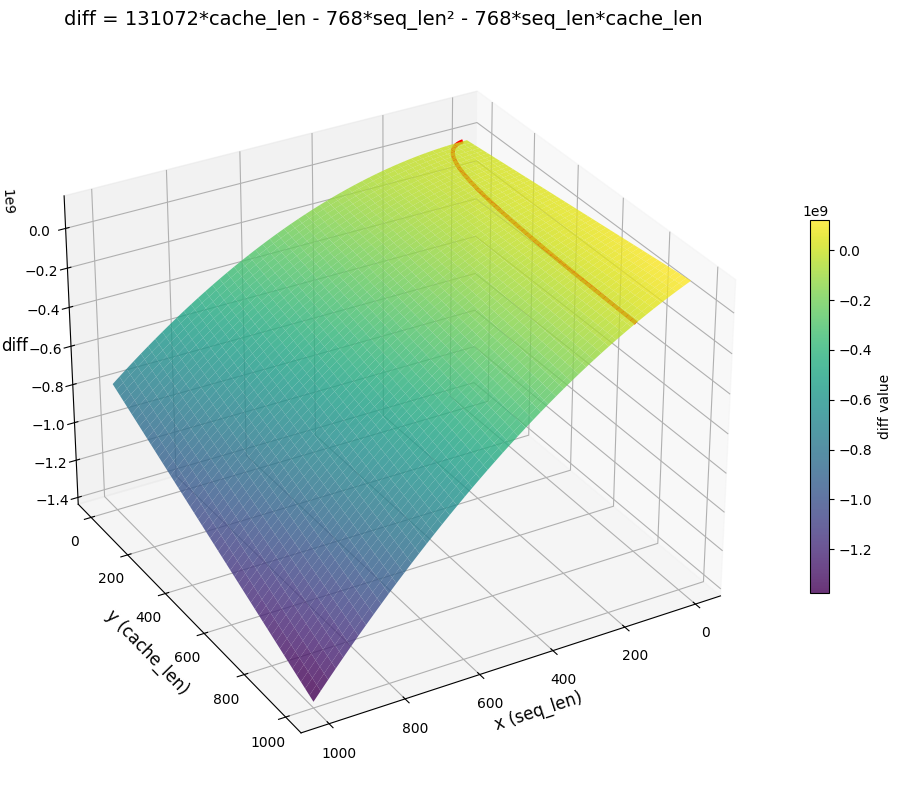

In [ ]:


# 创建数据
seq_len = np.linspace(1, 1000, 1000)  # seq_len从1到100
cache_len = np.linspace(1, 1000, 1000)  # cache_len从1到100

# 创建网格
X, Y = np.meshgrid(seq_len, cache_len)

# 计算函数值
Z = 131072 * Y - 768 * X**2 - 768 * X * Y

# 创建三维图形
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制曲面图
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)

# 添加 diff=0 的等高线（红色线）
zero_contour = ax.contour(X, Y, Z, levels=[0], colors='red', linewidths=3, linestyles='-', offset=-50000)


# 添加颜色条
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20, label='diff value')

# 设置坐标轴标签
ax.set_xlabel('x (seq_len)', fontsize=12)
ax.set_ylabel('y (cache_len)', fontsize=12)
ax.set_zlabel('diff', fontsize=12)

# 设置标题
ax.set_title('diff = 131072*cache_len - 768*seq_len² - 768*seq_len*cache_len', fontsize=14)

# 视角调整
ax.view_init(elev=30, azim=60)

# 显示图形
plt.tight_layout()
plt.show()



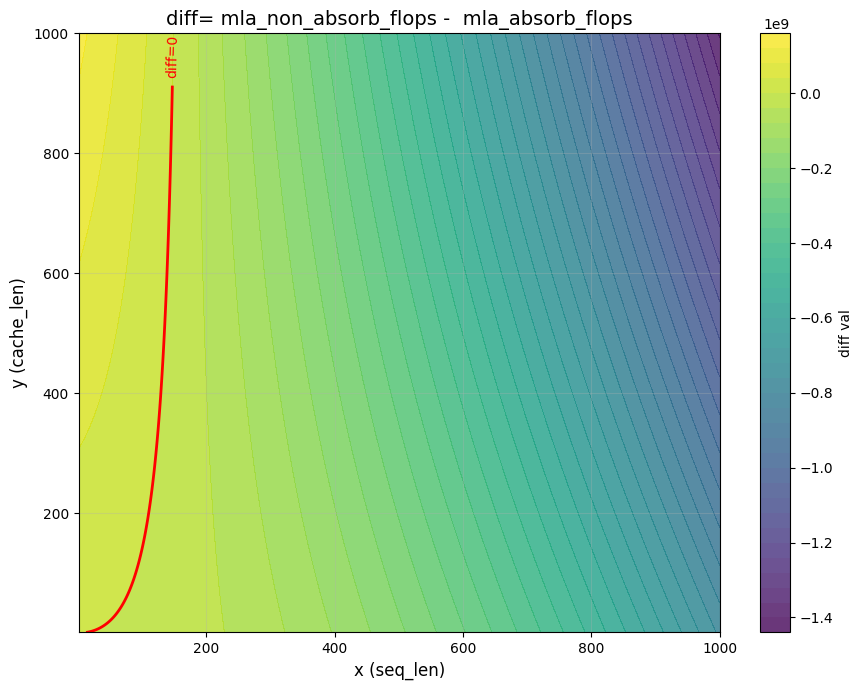

In [ ]:
# 绘制等高线图，并标记diff=0的红色线
fig2, ax2 = plt.subplots(figsize=(9, 7))

# 绘制填充等高线
contour = ax2.contourf(X, Y, Z, 50, cmap='viridis', alpha=0.8)

# 绘制等高线，特别标记diff=0的线
zero_contour = ax2.contour(X, Y, Z, levels=[0], colors='red', linewidths=2, linestyles='-')

# 在红色线上添加标签
ax2.clabel(zero_contour, inline=True, fontsize=10, fmt='diff=0')

# 添加颜色条
fig2.colorbar(contour, label='diff val')

# 设置坐标轴标签
ax2.set_xlabel('x (seq_len)', fontsize=12)
ax2.set_ylabel('y (cache_len)', fontsize=12)
ax2.set_title('diff= mla_non_absorb_flops -  mla_absorb_flops', fontsize=14)

# 添加网格以便更好地读取坐标
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 显存计算对比

In [ ]:
# 设定 seq 和 cache len：
seq_len = 1
cache_len = 4096 * 4

In [ ]:
# 非吸收矩阵
kv_up_proj = (bs * seq_len * kv_lora_rank +
              bs * heads * (seq_len + cache_len) * (qk_rope_head_dim + qk_head_dim + v_head_dim))
qkv_o_non_absorb_mem = bs * heads * seq_len * (qk_head_dim + qk_rope_head_dim) + \
                       bs * heads * (seq_len + cache_len) * (qk_rope_head_dim + qk_head_dim + v_head_dim) + \
                       bs * heads * seq_len * v_head_dim

max_val_non_absorb = max(kv_up_proj, qkv_o_non_absorb_mem) / (1024 * 1024 * 1024) # GB
print("kv_up_proj", kv_up_proj)
print("qkv_o_non_absorb_mem", qkv_o_non_absorb_mem)
print("max_val_non_absorb", max_val_non_absorb)

kv_up_proj 671130112
qkv_o_non_absorb_mem 671170560
max_val_non_absorb 0.6250762939453125


In [ ]:
# 吸收矩阵
q_absorb_mem = bs * heads * seq_len * (qk_head_dim + kv_lora_rank + qk_rope_head_dim)
o_absorb_mem = bs * heads * seq_len * (kv_lora_rank + v_head_dim)
qkv_o_absorb_mem = bs * heads * seq_len * (kv_lora_rank + qk_rope_head_dim) + \
            bs * heads * (seq_len + cache_len) * (kv_lora_rank + qk_rope_head_dim + kv_lora_rank) + \
            bs * heads * seq_len * kv_lora_rank
max_val_absorb = max(q_absorb_mem, o_absorb_mem, qkv_o_absorb_mem) / (1024 * 1024 * 1024)
print("q_absorb_mem", q_absorb_mem)
print("o_absorb_mem", o_absorb_mem)
print("qkv_o_mem", qkv_o_absorb_mem)
print("max_val_absorb", max_val_absorb)

q_absorb_mem 90112
o_absorb_mem 81920
qkv_o_mem 2281979904
max_val_absorb 2.1252593994140625


In [ ]:
print(f"The mem val diff:{max_val_absorb - max_val_non_absorb} GB")

The mem val diff:1.50018310546875 GB
